In [1]:
import sys
import os

if not os.getcwd() in sys.path:
    sys.path.append("%s/../.." % os.getcwd())

In [21]:
import numpy as np
import tensorflow as tf
from tensorflow.python.framework import ops
import matplotlib.pyplot as plt
from arsenal.data_process.load_data import DataLoader
from arsenal.data_process.plot_data import Ploter
from arsenal.common.basic_tool import random_mini_batches

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1、加载训练集和测试集数据

keys of train set:  ['list_classes', 'train_set_x', 'train_set_y']
keys of test set:  ['list_classes', 'test_set_x', 'test_set_y']
Shape of X of train set:  (1080, 64, 64, 3)
Shape of Y of train set:  (1, 1080)
Shape of X of test set:  (120, 64, 64, 3)
Shape of Y of test set:  (1, 120)


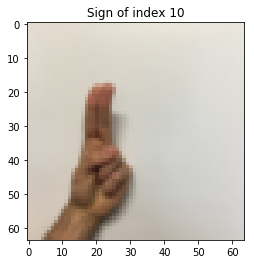

y =  2


In [3]:
data_train, key_lst_train = DataLoader().load("./data/train_signs.h5")
data_test, key_lst_test = DataLoader().load("./data/test_signs.h5")
print("keys of train set: ", key_lst_train)
print("keys of test set: ", key_lst_test)

X_train_orig, Y_train_orig = np.array(data_train["train_set_x"]), np.array([data_train["train_set_y"]])
X_test_orig, Y_test_orig = np.array(data_test["test_set_x"]), np.array([data_test["test_set_y"]])

print("Shape of X of train set: ", X_train_orig.shape)
print("Shape of Y of train set: ", Y_train_orig.shape)
print("Shape of X of test set: ", X_test_orig.shape)
print("Shape of Y of test set: ", Y_test_orig.shape)

index = 10

ploter = Ploter()
ploter.show_image(X_train_orig[index])
ploter.title("Sign of index %s" % (index))
ploter.show()
print("y = ", str(np.squeeze(Y_train_orig[:, index])))

## 2、数据预处理（归一化、变形为计算用）

In [4]:
# 计算最终损失函数需要one-hot形式的数据
def convert_to_one_hot(Y, C):
    return np.eye(C)[Y.reshape(-1)].T

X_train = X_train_orig / 255
X_test = X_test_orig / 255
Y_train = convert_to_one_hot(Y_train_orig, 6).T # 共五种手势
Y_test = convert_to_one_hot(Y_test_orig, 6).T

print("Shape of X_train: ", X_train.shape)
print("Shape of Y_train: ", Y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of Y_test: ", Y_test.shape)

Shape of X_train:  (1080, 64, 64, 3)
Shape of Y_train:  (1080, 6)
Shape of X_test:  (120, 64, 64, 3)
Shape of Y_test:  (120, 6)


## 3、模型介绍

X->CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED->Sigmoid->Y

## 4、设定模型参数
* 卷积
    卷积核尺寸，步长，padding模式(Same or Valid), padding用数值
* pool
    池化窗口尺寸、步长，模式(Max or Mean)

In [5]:
map = {
    'L0':{
        'cache':{
            'A': None, # 输入
        },
    },

    'L1':{
        'op_list': ['conv', 'activation', 'pool'],
        'conv':{
            'stride': 1,
            'cshape': [4, 4, None, 8], # [4, 4, 3, 8]
            'padding': 'SAME',
            'p_val': 0,
        },
        'activation': 'relu',
        'pool':{
            'stride': 8,
            'pshape': [8, 8],
            'mode': 'max',
            'padding': 'SAME',
        },

        'cache':{},
    },

    'L2':{
        'op_list': ['conv', 'activation', 'pool'],
        'conv':{
            'stride': 1,
            'cshape': [2, 2, None, 16], # [2, 2, 8, 16]
            'padding': 'SAME',
            'p_val': 0,
        },
        'activation': 'relu',
        'pool':{
            'stride': 4,
            'pshape': [4, 4],
            'mode': 'max',
            'padding': 'SAME'
        },
        
        'cache':{},
    },
    "L3":{
        'op_list': ['flatten'],
        'cache':{},
    },
    "L4":{
        'op_list': ['fc'],
        'cache':{},
    },
}

## 5、初始化参数

In [6]:
def create_placeholders(n_h0, n_w0, n_c0, n_y):
    X = tf.placeholder('float', shape=[None, n_h0, n_w0, n_c0])
    Y = tf.placeholder('float', shape=[None, n_y])
    
    return X, Y

In [7]:
X, Y = create_placeholders(64, 64, 3, 6)
print ("X = ", str(X))
print ("Y = ", str(Y))

X =  Tensor("Placeholder:0", shape=(?, 64, 64, 3), dtype=float32)
Y =  Tensor("Placeholder_1:0", shape=(?, 6), dtype=float32)


In [47]:
def initialize_params(map, seed=1):
    tf.set_random_seed(seed)
    
    L = len(map.keys()) - 3 # 去除输入、flatten、fc层
    
    for l in range(1, L+1):
        params = map["L"+str(l)]
        
        A_prev = map['L'+str(l-1)]['cache']['A']
        (m, n_h_prev, n_w_prev, n_c_prev) = A_prev.shape
        (n_ch, n_cw, _, n_c) = params['conv']['cshape']
        params['cache']['W'] = tf.get_variable('W'+str(l),
                                               [n_ch, n_cw, n_c_prev, n_c],
                                               initializer=tf.contrib.layers.xavier_initializer(seed=0))
        params['cache']['b'] = tf.get_variable('b'+str(l),
                                               [1, 1, 1, n_c], 
                                               initializer=tf.contrib.layers.xavier_initializer(seed=0))
        
        ops = params['op_list']
        n_h, n_w = n_h_prev, n_w_prev
        for op in ops:
            if 'conv' == op:
                padding_mode =  params['conv']['padding']
                if 'VALID' == padding_mode:
                    stride = params['conv']['stride']
                    n_h, n_w = (n_h-n_ch)//stride+1, (n_w-n_cw)//stride+1
            if 'activation' == op:
                n_h, n_w = n_h, n_w
            if 'pool' == op:
                padding_mode = params['pool']['padding']
                if 'VALID' == padding_mode:
                    stride = params['pool']['stride']
                    (n_ph, n_pw) = params['pool']['pshape']
                    n_h, n_w = (n_h-n_ph)//stride+1, (n_w-n_pw)//stride+1
        
        params['cache']['A'] = tf.zeros((m, n_h, n_w, n_c), name='A'+str(l))

In [48]:
map['L0']['cache']['A'] = X_test
tf.reset_default_graph()
with tf.Session() as sess_test:
    initialize_params(map)
    init = tf.global_variables_initializer()
    sess_test.run(init)
    print("W1 = ", str(map['L1']["cache"]['W'].eval()[1,1,1]))
    print("W2 = ", str(map['L2']["cache"]['W'].eval()[1,1,1]))
    print("W1 shape: ", map['L1']["cache"]['W'].shape)
    print("W2 shape: ", map['L2']["cache"]['W'].shape)
    print("b1 shape: ", map['L1']["cache"]['b'].shape)
    print("b2 shape: ", map['L2']["cache"]['b'].shape)
    print("A0 shape: ", map['L0']["cache"]['A'].shape)
    print("A1 shape: ", map['L1']["cache"]['A'].shape)
    print("A2 shape: ", map['L2']["cache"]['A'].shape)
    #print(map)

W1 =  [ 0.00131723  0.14176141 -0.04434952  0.09197326  0.14984085 -0.03514394
 -0.06847463  0.05245192]
W2 =  [-0.08566415  0.17750949  0.11974221  0.16773748 -0.0830943  -0.08058
 -0.00577033 -0.14643836  0.24162132 -0.05857408 -0.19055021  0.1345228
 -0.22779644 -0.1601823  -0.16117483 -0.10286498]
W1 shape:  (4, 4, 3, 8)
W2 shape:  (2, 2, 8, 16)
b1 shape:  (1, 1, 1, 8)
b2 shape:  (1, 1, 1, 16)
A0 shape:  (120, 64, 64, 3)
A1 shape:  (120, 64, 64, 8)
A2 shape:  (120, 64, 64, 16)


## 6、前向传播

In [37]:
def forward_propagation(X, map, n_y_class):
    
    map['L0']['cache']['A'] = X
    
    L = len(map.keys()) - 1
    
    for l in range(1, L+1):
        params = map['L'+str(l)]
        A_prev = map['L'+str(l-1)]['cache']['A']
        
        ops = params['op_list']
        A = A_prev
        for op in ops:
            #print("layer: ", l, " ", op, ": ", A, " shape: ", A.shape)
            if 'conv' == op:
                W = params['cache']['W']
                b = params['cache']['b']
                stride = params['conv']['stride']
                padding_mode = params['conv']['padding']
                A = tf.nn.conv2d(A, W, strides=[1,stride,stride,1], padding=padding_mode) + b
            if 'activation' == op:
                act_func = params['activation']
                if "relu" == act_func:
                    A = tf.nn.relu(A)
                if "sigmoid" == act_func:
                    A = tf.sigmoid(A)
            if 'pool' == op:
                mode = params['pool']['mode']
                padding_mode = params['pool']['padding']
                pshape = params['pool']['pshape']
                stride = params['pool']['stride']
                if "max" == mode:
                    A = tf.nn.max_pool(A,
                                       ksize=[1,pshape[0],pshape[1],1],
                                       strides=[1,stride,stride,1],
                                       padding='SAME')
                if 'avg' == mode:
                    A = tf.nn.avg_pool(A,
                                       ksize=[1,pshape[0],pshape[1],1],
                                       strides=[1,stride,stride,1],
                                       padding=padding_mode)
            if 'flatten' == op:
                A = tf.contrib.layers.flatten(A)
            if 'fc' == op:
                A = tf.contrib.layers.fully_connected(A, n_y_class, activation_fn=None)
                
            #print("layer: ", l, " ", op, ": ", A, " shape: ", A.shape)
        
        params['cache']['A'] = A
        #print('layer: ', l, map['L'+str(l)]['cache']['A'])
        
    return params['cache']['A']
                

In [38]:
forward_pro_test_map = {
    'L0':{
        'cache':{
            'A': None, # 输入
        },
    },

    'L1':{
        'op_list': ['conv', 'activation', 'pool'],
        'conv':{
            'stride': 1,
            'cshape': [4, 4, None, 8], # [4, 4, 3, 8]
            'padding': 'SAME',
            'p_val': 0,
        },
        'activation': 'relu',
        'pool':{
            'stride': 8,
            'pshape': [8, 8],
            'mode': 'max',
            'padding': 'SAME',
        },

        'cache':{},
    },

    'L2':{
        'op_list': ['conv', 'activation', 'pool'],
        'conv':{
            'stride': 1,
            'cshape': [2, 2, None, 16], # [2, 2, 8, 16]
            'padding': 'SAME',
            'p_val': 0,
        },
        'activation': 'relu',
        'pool':{
            'stride': 4,
            'pshape': [4, 4],
            'mode': 'max',
            'padding': 'SAME'
        },
        
        'cache':{},
    },
    "L3":{
        'op_list': ['flatten'],
        'cache':{},
    },
    "L4":{
        'op_list': ['fc'],
        'cache':{},
    },
}

tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(64, 64, 3, 6)
    forward_pro_test_map['L0']['cache']['A'] = X_test
    initialize_params(forward_pro_test_map)
    AL = forward_propagation(X, forward_pro_test_map, 6)
    
    init = tf.global_variables_initializer()
    sess.run(init)
    
#     print(sess.run(forward_pro_test_map['L1']['cache']['W']).shape)
#     print(sess.run(forward_pro_test_map['L2']['cache']['W']).shape)
#     print(sess.run(forward_pro_test_map['L1']['cache']['W']))
#     print(sess.run(forward_pro_test_map['L2']['cache']['W']))
    
    a = sess.run(AL, {X: np.random.randn(2,64,64,3), Y: np.random.randn(2,6)})
    print("AL = " + str(a))

AL = [[ 5.55666304 -1.26528537 -0.56199872  2.28329372 -0.74298126  1.27531385]
 [ 5.36049891 -1.33965254 -0.96124303  2.41839457 -0.75064147  1.31371319]]


## 7、计算Loss

In [39]:
def compute_loss(AL, Y):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=AL, labels=Y))
    return loss

In [40]:
tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(64, 64, 3, 6)
    Z3 = np.array([[-0.44670227, -1.57208765, -1.53049231, -2.31013036, -1.29104388, 0.46852064],
                 [-0.17601591, -1.57972014, -1.4737016,  -2.61672091, -1.00810623, 0.57477844],
                 [-0.05643788, -1.59197772, -1.26757252, -2.30188441, -1.37652016, 0.04895034],
                 [-0.0433749, -1.69219863, -1.31829095, -2.01874852, -1.46148038, 0.11337087]])
    loss = compute_loss(Z3, Y)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(loss, {Y: np.random.randn(4,6)})
    print("cost = " + str(a))

cost = 0.0431104947329


## 8、建立训练模型

In [51]:
def model(map, X_train, Y_train, X_test, Y_test, learning_rate=0.009,
         num_epochs=100, minibatch_size=64, print_cost=True):
    
    ploter = Ploter()
    map['L0']['cache']['A'] = X_train
    
    ops.reset_default_graph()
    tf.set_random_seed(1)
    seed = 3
    (m, n_h0, n_w0, n_c0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    losses = []
    
    X, Y = create_placeholders(n_h0, n_w0, n_c0, n_y)
    initialize_params(map)
    
    AL = forward_propagation(X, map, n_y)
    
    loss = compute_loss(AL, Y)
    
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train = optimizer.minimize(loss)
    
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        
        for epoch in range(num_epochs):

            minibatch_loss = 0.
            num_minibatches = m // minibatch_size
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                (minibatch_X, minibatch_Y) = minibatch
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                ### START CODE HERE ### (1 line)
                _ , temp_loss = sess.run([train,loss], feed_dict={X:minibatch_X, Y:minibatch_Y})
                ### END CODE HERE ###
                
                minibatch_loss += temp_loss / num_minibatches
                

            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Loss after epoch %i: %f" % (epoch, minibatch_loss))
            if print_cost == True and epoch % 1 == 0:
                losses.append(minibatch_loss)
        
        
        # plot the cost
        ploter.plot(losses)
        ploter.label(1, 'loss')
        ploter.label(0, 'iterations (per tens)')
        ploter.title("Learning rate =" + str(learning_rate))
        ploter.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(AL, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy

Loss after epoch 0: 1.927543
Loss after epoch 5: 1.424566
Loss after epoch 10: 0.913696
Loss after epoch 15: 0.747439
Loss after epoch 20: 0.599385
Loss after epoch 25: 0.467615
Loss after epoch 30: 0.392038
Loss after epoch 35: 0.361558
Loss after epoch 40: 0.332040
Loss after epoch 45: 0.298857
Loss after epoch 50: 0.251589
Loss after epoch 55: 0.206081
Loss after epoch 60: 0.205037
Loss after epoch 65: 0.193679
Loss after epoch 70: 0.181153
Loss after epoch 75: 0.174469
Loss after epoch 80: 0.128001
Loss after epoch 85: 0.117240
Loss after epoch 90: 0.105759
Loss after epoch 95: 0.098463


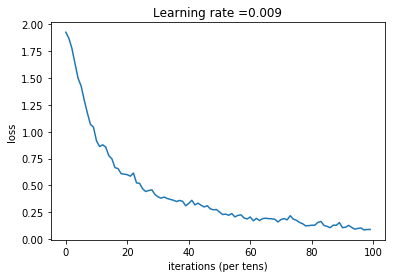

Train Accuracy: 0.983333
Test Accuracy: 0.875


In [52]:
_,_ = model(map, X_train, Y_train, X_test, Y_test)